In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

In [2]:
import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [3]:
from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


# 1. RGP: NO CONTROL SIGNAL

In [34]:
# Function to show 3D image of a human given the data as an array
def gen_frames(data, data_mean, data_std, skel):#, imgpath):
    import os
    import GPy
    a = np.zeros((62,))
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d',aspect='equal')
    ax.view_init(elev=20., azim=65)
    fig.tight_layout()
    a[3:] = (data[0])*data_std+data_mean
    p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
#     help(p)
#     for i in range(data.shape[0]):
    for i in range(50):
        a[3:] = (data[i])*data_std+data_mean
        a[1] = i
        p.modify(a)
#         plt.plot()
        #plt.plot(p)
    plt.show()
        #fig.savefig(os.path.join(imgpath,'%05d'%i+'.png'))


### Extract data

In [4]:
train_motions = ['01', '02', '03', '04']
test_motions = ['05', '06', '07', '08']
subject = '35'
m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_list, y_train_mean_list, y_train_std_list = [],[],[]
for item in y_train:
    out, mean, std = helper.normalise_data(item)
    y_train_list.append(out)
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
    
    
y_test_list, y_test_mean_list, y_test_std_list = [], [], []
for item in y_test:
    out, mean, std = helper.normalise_data(item)
    y_test_list.append(out)
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)


In [5]:
## Function to show 3D motion sequence of a human
def save_trail(data, data_mean, data_std, skel, filename):
    import os
    import GPy
    a = np.zeros((62,))
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=0., azim=20)
    ax.set_ylim3d([-10, 130])
    ax.set_zlim3d([-20, 20])
    ax.set_xlim3d([-15, 15])
    for i in range(13,26):
        a[3:] = (data[i*3])*data_std+data_mean
        a[2] = (i-15)*13
        p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
    plt.show()
    fig.savefig(filename)

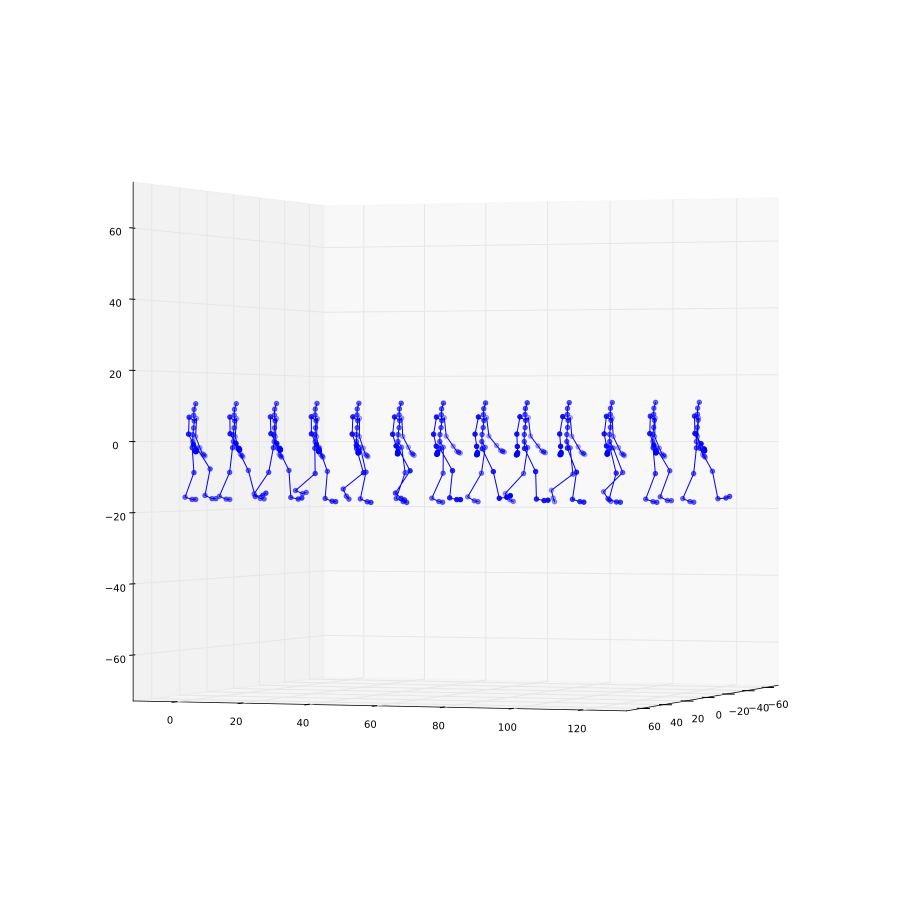

In [6]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)
y = helper.reshape(y_test_list)

save_trail(y[1][:,3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "original")

## 1.1 RGP: fully observed, no control signal
Window size 20 works best, when increased window size to 30 the posterior clappse to the prior. So from emperical results, longer window size doesn't mean it's better given limited training iterations.
In general, longer window size means higher dimension for covariance matrix. Therefore, more iterations are needed to train the model. Window 30 and 20 gives similar results after successful training. Considering overall training time, the window size is chosen to be 20 to reduce the computation cost.

In [13]:
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
         'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
         'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
         'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

for idx, y_train in enumerate(y_train_list):
    print("===============" + bones[idx] + "=============")
    ## Initialize model
    D = np.shape(y_train[0])[1]
    win_out = 20
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=100,
            kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*D,)),np.float64))
    m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.00001]),np.float64))
    
    ## Train model
    m.optimize(Y=y_train, max_iters=500, step_rate=0.2)
    m.optimize(Y=y_train, max_iters=500, step_rate=0.1)
    m.optimize(Y=y_train, max_iters=800, step_rate=0.05)
    
    ## Save model
    m.save_params('./models/no_control_fully_observed/'+bones[idx]) 

  0%|          | 0/500 [00:00<?, ?it/s]

===============root=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfemur=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============ltibia=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfoot=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============ltoes=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfemur=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rtibia=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfoot=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rtoes=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lowerback=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============upperback=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============thorax=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lowerneck=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============upperneck=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============head=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lclavicle=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lhumerus=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lradius=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lwrist=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lhand=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfingers=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lthumb=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rclavicle=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rhumerus=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rradius=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rwrist=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rhand=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfingers=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rthumb=============


100%|██████████| 800/800 [02:25<00:00,  5.50it/s, loss=740]    


In [5]:
def test_run(model, seq, win_out, test_data, MEAN_PRED=True):
    D = np.shape(test_data[0])[-1]
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=100, kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    m.load_params('./models/no_control_fully_observed/'+model)
    y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
    y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [6]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

win_out = 20
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('=============== '+model+' ================')
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, y_test_list[i]) # output array
#         print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
#             print(y_pds[seq].shape)


=============== root ================
=============== lfemur ================
=============== ltibia ================
=============== lfoot ================
=============== ltoes ================
=============== rfemur ================
=============== rtibia ================
=============== rfoot ================
=============== rtoes ================
=============== lowerback ================
=============== upperback ================
=============== thorax ================
=============== lowerneck ================
=============== upperneck ================
=============== head ================
=============== lclavicle ================
=============== lhumerus ================
=============== lradius ================
=============== lwrist ================
=============== lhand ================
=============== lfingers ================
=============== lthumb ================
=============== rclavicle ================
=============== rhumerus ================
=============== rradius 

In [7]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
for seq, pd in enumerate(pds):
    filename = './predictions/no_control_fully_ovseved_seq'+str(seq)
    helper.write_amc(pd, filename)

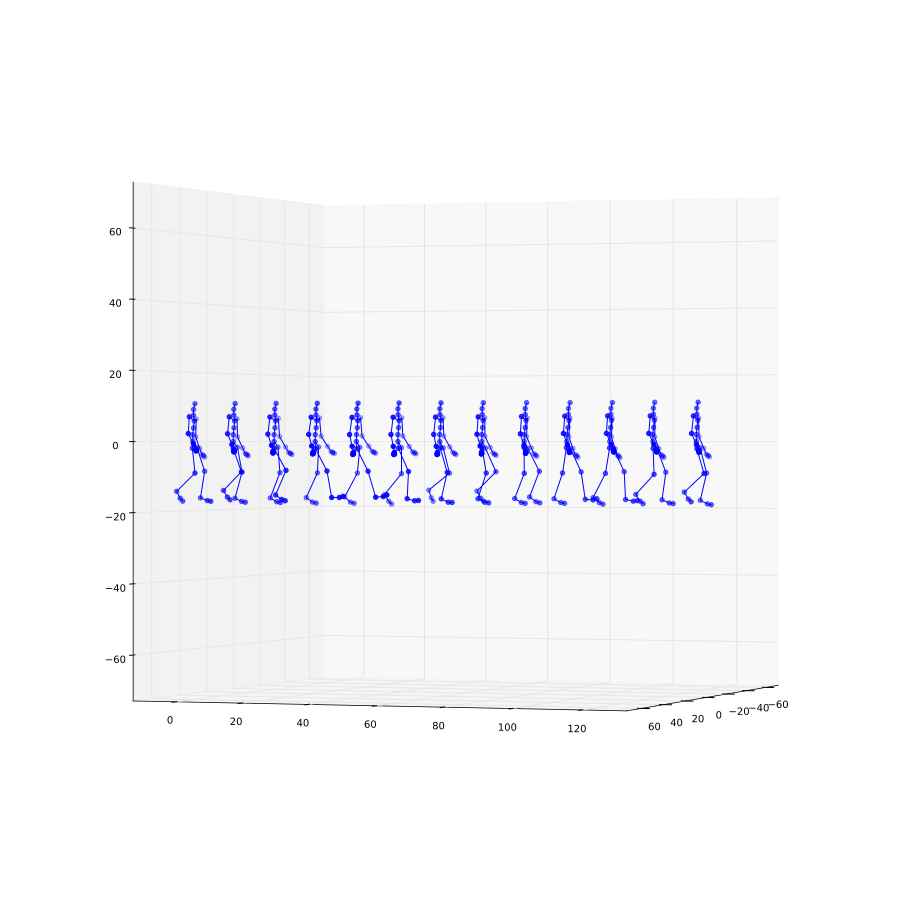

In [8]:
helper.save_trail(y_pds[0][:,3:], mean_list[0][3:], std_list[0][3:], m1['skel'], "no_control_fully_observed")

###  Compute MSE

In [14]:
MSE = compute_MSE(y_test_list, y_pds)
print(MSE)

[0.4584332236925649, 0.43197184991195464, 0.4051233793622853, 0.44327737685522695]


In [ ]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
win_out = 30
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('===============  '+model+'   ================')
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, y_test_list[i]) # output array
        #print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))


In [26]:
## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
## lfingers and rfingers have constant values therefore, goes to 0 after normalisation. 
## mannually add original values to the final predictions.
for i in range(4):
    pds[i][:,20:21] = y_test[20][i] #lfingers
    pds[i][:,-4:-3] = y_test[27][i] #rfingers
    
# print(y_train[20][3]) #lfingers original data
#print(y_train[27][2]) #lfingers original data
for seq, pd in enumerate(pds):
    filename = './predictions/test/seq'+str(seq)
    write_amc(pd, filename)

## Plots of results on training data: 6 dimension of root

In [20]:
def plot_pred(seq, win_out, model, data_in, dim, Save=False):
    D = np.shape(data_in[0])[-1]; print('Dimensions: ', D)
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=100, kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    m.load_params('./models/no_control_fully_observed/'+model)
    #data_in[seq].shape[0]-win_out
    y_pd = m.freerun(data_in[seq].shape[0]-win_out, init_X=data_in[seq][:win_out,:], mean_predict=False, nSamples=100)
    pred_mean, = plot(y_pd[:,:,dim].mean(0),'b', label='prediction-mean')
    pred_var, = plot(y_pd[:,:,dim].mean(0)-y_pd[:,:,dim].std(0)*2, 'b--', label='prediction-variance')
    plot(y_pd[:,:,dim].mean(0)+y_pd[:,:,dim].std(0)*2, 'b--')
    ground_truth, =plot(data_in[seq][:,dim],'r',label='ground-truth')
    ylabel('Normalised Value')
    xlabel('Samples')
    title(model+': Dimension-'+str(dim+1))
    legend(handles=[pred_mean, pred_var, ground_truth], prop={'size':7})
    if Save:
        savefig('./images/'+model+str(dim))

Dimensions:  2


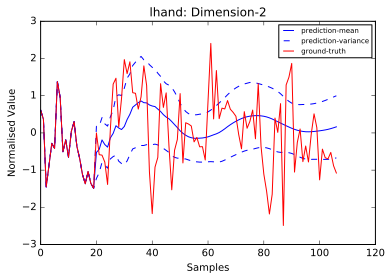

In [22]:
## NEW
plot_pred(0, 20, 'lhand', y_test_list[19], 1, Save=True)

Dimensions:  2


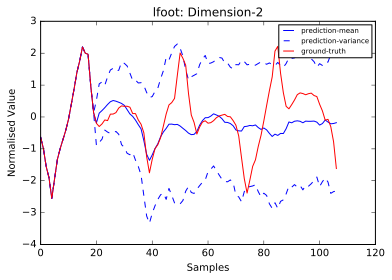

In [10]:
## NEW
plot_pred(0, 20, 'lfoot', y_test_list[3], 1)

Dimensions:  6


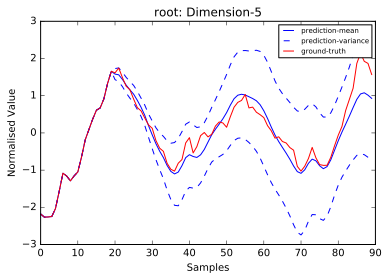

In [23]:
plot_pred(0, 20, 'root', y_train_list[0], 4, Save=True)

Dimensions:  6


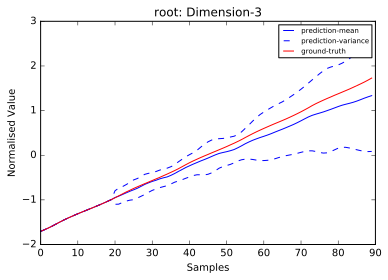

In [24]:
plot_pred(0, 20, 'root', y_train_list[0], 2, Save=True)

# 2. RGP: WITH CONTROL SIGNAL

Training with control signal only experimented on one feature. Control signal is root 3 angle dimension and 3 3d coordinate dimensions, and output signal is the lowerback 3-dimensiona angle 

In [5]:
train_motions = ['01', '02', '03', '04']
test_motions = ['05', '06', '07', '08']
subject = '35'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [36]:
np.shape(y_train[0][0])

(90, 6)

## 2.1 RGP: no hidden layer, with control signal

Test control signal is chosen to be the 3d coordinate of the root position.

In [6]:
for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = helper.compute_delta(y_train_dict["root"])
    else:
        u_train = y_train_dict[u_bones[j]] 
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal
     
    ## Initialise model
    win_out = 20 # only consider the feature from previous time step
    win_in = 20
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=400,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*5,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.05)

    m_control.save_params('./models/control_fully_observed/'+str(bone))

0-root


100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s, loss=-2.13e+03]


AttributeError: 'SVIRGPLayer' object has no attribute 'post_wv'

## Plot training results with control signal

In [17]:
def pred_plot(seq, win_out, win_in, model, data_in, control_signal, dim):
    YD = np.shape(data_in[0])[-1]; print('Observationa dimension:', YD)
    UD = 1 if model is 'root' else np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
    m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=400, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], 
            ctx=ctx, dtype=np.float64)
    m.load_params('./models/control_signal/fully_observed/'+model)
    #data_in[seq].shape[0]-win_out
    y_pd = m.layers[0].freerun(200, init_X=data_in[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
    pred_mean, = plot(y_pd[:,:,dim].mean(0),'b', label='prediction-mean')
    pred_var, = plot(y_pd[:,:,dim].mean(0)-y_pd[:,:,dim].std(0)*2, 'b--', label='prediction-variance')
    plot(y_pd[:,:,dim].mean(0)+y_pd[:,:,dim].std(0)*2, 'b--')
    ground_truth, =plot(data_in[seq][:,dim],'r',label='ground-truth')
    ylabel('Normalised Value')
    xlabel('Samples')
    title(model+': Dimension-'+str(dim+1))
    legend(handles=[pred_mean, pred_var, ground_truth], prop={'size':7})
    savefig('./images/control/test_'+model+str(dim))
#     savefig('./images/control/train_'+model+str(dim))

Observationa dimension: 6
Control signal dimension: 1


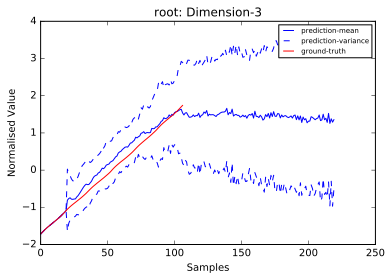

In [25]:
y_train = y_test_dict['root']
u_train = [np.ones((220,1)), np.ones((220,1)), np.ones((220,1)), np.ones((220,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 2)

Observationa dimension: 6
Control signal dimension: 1


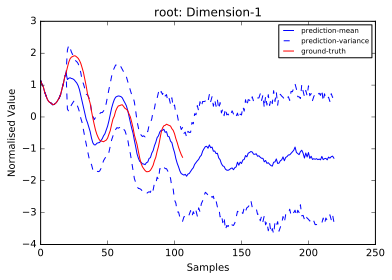

In [26]:
y_train = y_test_dict['root']
u_train = [np.ones((220,1)), np.ones((220,1)), np.ones((220,1)), np.ones((220,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 0)

Observationa dimension: 6
Control signal dimension: 1


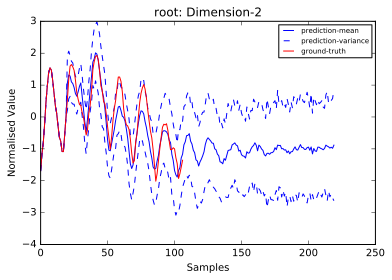

In [27]:
y_train = y_test_dict['root']
u_train = [np.ones((220,1)), np.ones((220,1)), np.ones((220,1)), np.ones((220,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 1)

In [65]:
y_train_list, y_test_list = [], []
for j, bone in enumerate(y_bones):  
#     print(str(j)+'-'+bone)
    y_train_list.append(y_train_dict[bone])
    y_test_list.append(y_test_dict[bone])
    if bone is 'root':
        u_train_list = [ [np.ones((np.shape(y_train[0][0])[0],1)),
                       np.ones((np.shape(y_train[0][1])[0],1)),
                       np.ones((np.shape(y_train[0][2])[0],1)),
                       np.ones((np.shape(y_train[0][3])[0],1))] ]
        
        u_test_list = [ [np.ones((np.shape(y_test[0][0])[0],1)),
                       np.ones((np.shape(y_test[0][1])[0],1)),
                       np.ones((np.shape(y_test[0][2])[0],1)),
                       np.ones((np.shape(y_test[0][3])[0],1))] ]
    else:
        u_train_list.append(y_train_dict[u_bones[j]])
        u_test_list.append(y_test_dict[u_bones[j]])
     

In [67]:
def test_run(model, seq, win_out, win_in, test_data, control_signal, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = 1 if model is 'root' else np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
        m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=400, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], 
            ctx=ctx, dtype=np.float64)
        m.load_params('./models/control_signal/fully_observed/'+model)
    
        y_pd = m.layers[0].freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [68]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

win_out = 20
win_in = 20
num_train_seq = np.shape(y_train_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('===============  '+model+'   ================')
    for seq in range(num_train_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_train_list[i], u_train_list[i], MEAN_PRED=True, with_control=True) # output array
#         print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
#             print(y_pds[seq].shape)


===============  root   ================
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
===============  lfemur   ================
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
===============  ltibia   ================
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
===============  lfoot   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimensio

 /home/yw440/MXRGP/mxgpy/util.py:182: RuntimeWarning:invalid value encountered in greater


Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
===============  lthumb   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
===============  rclavicle   ================
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
===============  rhumerus   ================
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
===============  rradius   ================
Observationa

NameError: name 'mean_list' is not defined

In [72]:
mean_list = reshape(y_train_mean_list)
std_list = reshape(y_train_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
## lfingers and rfingers have constant values therefore, goes to 0 after normalisation. 
## mannually add original values to the final predictions.
for i in range(4):
    pds[i][:,20:21] = y_train_list[20][i] #lfingers
    pds[i][:,-4:-3] = y_train_list[27][i] #rfingers
    
# print(y_train[20][3]) #lfingers original data
#print(y_train[27][2]) #lfingers original data
for seq, pd in enumerate(pds):
    filename = './predictions/with_control/train/seq'+str(seq)
    write_amc(pd, filename)


In [73]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

win_out = 20
win_in = 20
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('===============  '+model+'   ================')
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test_list[i]) # output array
#         print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
#             print(y_pds[seq].shape)

mean_list = reshape(y_test_mean_list)
std_list = reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    


===============  root   ================
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
===============  lfemur   ================
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
===============  ltibia   ================
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
===============  lfoot   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimensio

 /home/yw440/MXRGP/mxgpy/util.py:182: RuntimeWarning:invalid value encountered in greater


Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
===============  lthumb   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
===============  rclavicle   ================
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
===============  rhumerus   ================
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
===============  rradius   ================
Observationa

ValueError: could not broadcast input array from shape (90,1) into shape (107,1)

In [74]:
## lfingers and rfingers have constant values therefore, goes to 0 after normalisation. 
## mannually add original values to the final predictions.
for i in range(4):
    pds[i][:,20:21] = y_test_list[20][i] #lfingers
    pds[i][:,-4:-3] = y_test_list[27][i] #rfingers
    
# print(y_train[20][3]) #lfingers original data
#print(y_train[27][2]) #lfingers original data
for seq, pd in enumerate(pds):
    filename = './predictions/with_control/test/seq'+str(seq)
    write_amc(pd, filename)

# TOY EXAMPLE - Sine wave

In [1]:
import numpy as np
Fs, f, sample = 200, 4, 500
x = np.arange(sample)
yx = np.sin(2*np.pi*f*x/Fs).reshape(sample,1)


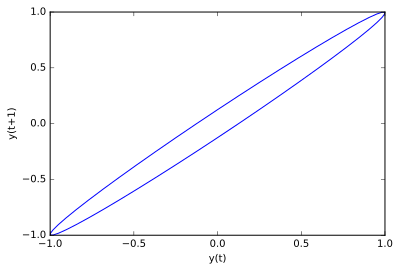

In [9]:
plot(yx[:-1], yx[1:])
xlabel('y(t)')
ylabel('y(t+1)')

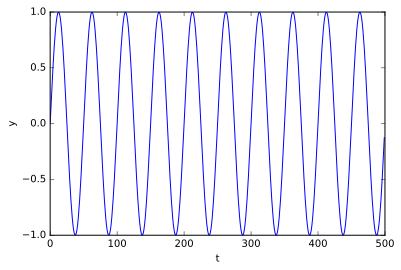

In [10]:
plot(x,yx)
xlabel('t')
ylabel('y')

In [6]:
D = 1 #np.shape(yx)[1] # dimension of the data, 62 dimension
win_out = 20 # only consider the feature from previous time step
m_sin = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=50,
       kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)

In [10]:
m_sin.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([1.]), np.float64))
m_sin.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(win_out*D),np.float64))
m_sin.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.5]),np.float64))

In [15]:
m_sin.optimize(Y=[yx[win_out:]], max_iters=200, step_rate=0.01)

100%|██████████| 200/200 [00:25<00:00,  7.99it/s, loss=-996]


In [10]:
m_sin.save_params('test')

In [11]:
m_sin.load_params('test')

In [16]:
y_sin = m_sin.freerun(yx.shape[0]-win_out, init_X=yx[:win_out], mean_predict=False, nSamples=100)

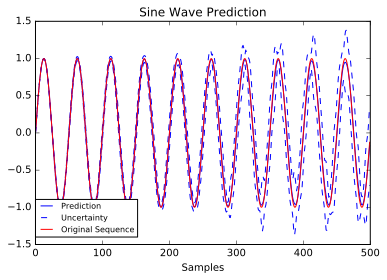

In [17]:
pred, = plot(y_sin[:,:,0].mean(0),'b')
lower, = plot(y_sin[:,:,0].mean(0)-y_sin[:,:,0].std(0)*2, 'b--')
upper, = plot(y_sin[:,:,0].mean(0)+y_sin[:,:,0].std(0)*2, 'b--')
orig, = plot(yx[:,0],'r',label='ground-truth')
xlabel("Samples")
title("Sine Wave Prediction")
# legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(0., .1, 1., .102), loc=2,
          fontsize=8, ncol=1, borderaxespad=0.)
savefig("sine_wave.png")

In [19]:
y_sin = m_sin.freerun(1000, init_X=yx[:win_out], mean_predict=False, nSamples=100)

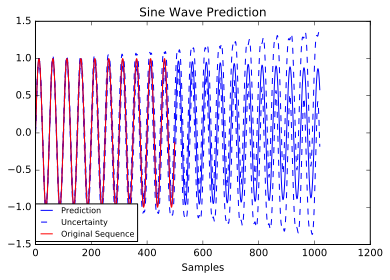

In [20]:
plot(y_sin[:,:,0].mean(0),'b')
plot(y_sin[:,:,0].mean(0)-y_sin[:,:,0].std(0)*2, 'b--')
plot(y_sin[:,:,0].mean(0)+y_sin[:,:,0].std(0)*2, 'b--')
plot(yx[:,0],'r',label='ground-truth')
xlabel("Samples")
title("Sine Wave Prediction")
legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(0., .08, 1., .102), loc=2,
          fontsize=8, ncol=1, borderaxespad=0.)
plt.savefig("sine_wave(long).png")

In [ ]:
m_sin.show_params()